In [51]:
!pip install nltk
!pip install matplotlib
!pip install seaborn
import pandas as pd
import numpy as np
# import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
from collections import Counter, defaultdict
import nltk
# from wordcloud import WordCloud

In [52]:
file_list = ('icse22_mixed_v1.json','icse22_recent_v1.json','icse2022_mixed_v1.json','icse2022_recent_v4.json')
icse_tweets = []
for path in file_list:
    with open(path) as f:
        loaded_tweets = json.load(f)
        print(f"Loaded {len(loaded_tweets)} tweets from '{path}'")
        ids = [t['id'] for t in icse_tweets]
        for t in loaded_tweets:
            if t['id'] not in ids:
                icse_tweets.append(t)
        print(f"Gathered {len(icse_tweets)} tweets")

Loaded 68 tweets from 'icse22_mixed_v1.json'
Gathered 68 tweets
Loaded 75 tweets from 'icse22_recent_v1.json'
Gathered 82 tweets
Loaded 388 tweets from 'icse2022_mixed_v1.json'
Gathered 470 tweets
Loaded 542 tweets from 'icse2022_recent_v4.json'
Gathered 642 tweets


In [53]:
def is_RT(tweet):
    if 'retweeted_status' not in tweet:
        return False      
    else:
        return True

def is_Reply_to(tweet):
    if 'in_reply_to_screen_name' not in tweet:
        return False      
    else:
        return tweet['in_reply_to_screen_name']

tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['full_text'] if 'extended_tweet' not in tweet else tweet['extended_tweet']['full_text'], icse_tweets))
tweets['Username'] = list(map(lambda tweet: tweet['user']['screen_name'], icse_tweets))
tweets['timestamp'] = list(map(lambda tweet: tweet['created_at'], icse_tweets))
tweets['length'] = list(map(lambda tweet: len(tweet['full_text']) if'extended_tweet' not in tweet else len(tweet['extended_tweet']['full_text']), icse_tweets))
# tweets['location'] = list(map(lambda tweet: tweet['user']['location'], icse_tweets))
tweets['RT'] = list(map(is_RT, icse_tweets))
tweets['Reply'] = list(map(is_Reply_to, icse_tweets))
tweets['favorites'] = list(map(lambda tweet: tweet['favorite_count'], icse_tweets))
tweets['retweets'] = list(map(lambda tweet: tweet['retweet_count'], icse_tweets))
tweets['url'] = list(map(lambda t: f"https://twitter.com/{t['user']['screen_name']}/{t['id_str']}", icse_tweets))

In [54]:
tweets.head()

,text,Username,timestamp,length,RT,Reply,favorites,retweets,url
0,RT @ICSEconf: #ICSE22 just finished. But we ha...,heiko_braun,Thu Jun 02 11:11:32 +0000 2022,140,True,None,0,3,https://twitter.com/heiko_braun/15323189946397...
1,RT @ICSEconf: #ICSE22 just finished. But we ha...,ivanmachado,Thu Jun 02 01:20:18 +0000 2022,140,True,None,0,3,https://twitter.com/ivanmachado/15321702057989...
2,RT @ICSEconf: #ICSE22 just finished. But we ha...,jeremy_bradbury,Thu Jun 02 00:37:41 +0000 2022,140,True,None,0,3,https://twitter.com/jeremy_bradbury/1532159481...
3,#ICSE22 just finished. But we have some memori...,ICSEconf,Wed Jun 01 22:02:54 +0000 2022,141,False,None,25,3,https://twitter.com/ICSEconf/1532120530068946951
4,RT @cestlemieux: Had a great time seeing every...,ubc_spl,Wed Jun 01 17:10:49 +0000 2022,140,True,None,0,1,https://twitter.com/ubc_spl/1532047024626880512


In [55]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chrisma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [56]:
def determine_sentiment(tweet):
    sentiment = sid.polarity_scores(tweet["full_text"])
    
    if sentiment["compound"] >= .5:
        return "positive"
    elif sentiment["compound"] <= -.5:
        return "negative"
    else:
        return "neutral"
    
tweets["sentiment"] = list(map(determine_sentiment, icse_tweets))
tweets["senti_score"] = list(map(lambda t: sid.polarity_scores(t['full_text'])['compound'], icse_tweets))

In [57]:
original_tweets = tweets[tweets["RT"] == False]
original_tweets.head()

,text,Username,timestamp,length,RT,Reply,favorites,retweets,url,sentiment,senti_score
3,#ICSE22 just finished. But we have some memori...,ICSEconf,Wed Jun 01 22:02:54 +0000 2022,141,False,None,25,3,https://twitter.com/ICSEconf/1532120530068946951,neutral,0.0000
5,Had a great time seeing everyone in person aga...,cestlemieux,Wed Jun 01 14:42:24 +0000 2022,200,False,None,35,1,https://twitter.com/cestlemieux/15320096727560...,positive,0.8856
6,@clegoues @ICSEconf Negative here in London #i...,rchatley,Wed Jun 01 07:12:23 +0000 2022,94,False,clegoues,5,0,https://twitter.com/rchatley/1531896425814138887,negative,-0.5719
10,Bronze medal at the #ICSE22 SRC! 🥉 Congrats to...,SeSa_Lab,Sun May 29 08:09:40 +0000 2022,103,False,None,14,3,https://twitter.com/SeSa_Lab/1530823678509862912,positive,0.7955
11,A compelling proposal for extracting formal gr...,breandan,Sun May 29 00:55:33 +0000 2022,302,False,None,5,0,https://twitter.com/breandan/1530714428064141312,positive,0.7955


  sentiment  count
0  negative      6
1   neutral    132
2  positive    143


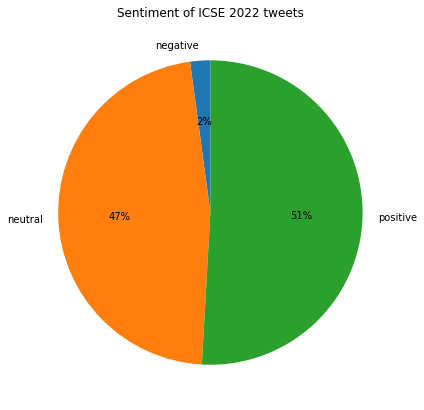

In [58]:
grouped = original_tweets.groupby(['sentiment'])['sentiment']

grouped_df = pd.DataFrame(grouped.size().reset_index(name = "count"))

print(grouped_df)

#colors = ["#CA7165", "#65C9CA", "#6DCA65"]

plt.figure(figsize=(7,7))
# create pie chart using matplotlib
plt.pie(grouped_df["count"], labels=grouped_df["sentiment"], autopct='%.0f%%', startangle=90)
plt.title("Sentiment of ICSE 2022 tweets")
# plt.savefig('sentiment_images/pie_chart.jpg', bbox_inches='tight')  
plt.show()

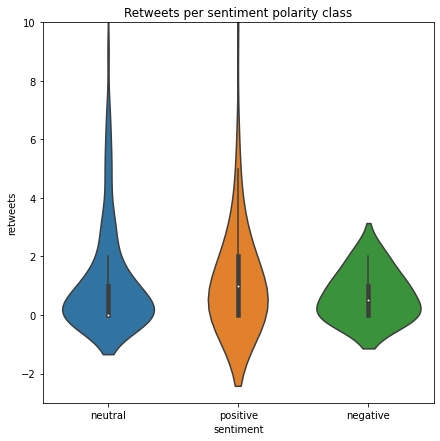

In [59]:
plt.figure(figsize=(7,7))

ax = sns.violinplot(x="sentiment", y="retweets", data=original_tweets)

ax.set_title("Retweets per sentiment polarity class")

ax.set_ylim(-3,10)

#plt.savefig('sentiment_images/retweets_violin.jpg', bbox_inches='tight') 
plt.show()

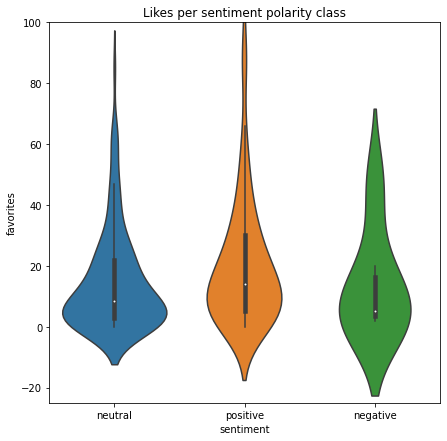

In [60]:
plt.figure(figsize=(7,7))

ax = sns.violinplot(x="sentiment", y="favorites", data=original_tweets)

ax.set_title("Likes per sentiment polarity class")

ax.set_ylim(-25,100)

# plt.savefig('sentiment_images/likes_violin.jpg', bbox_inches='tight') 
plt.show()

<Figure size 576x576 with 0 Axes>

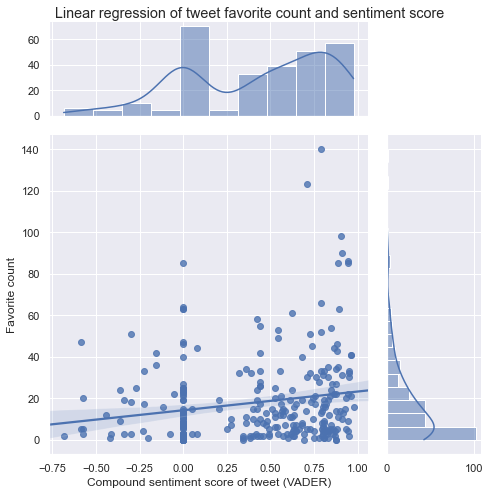

<Figure size 576x576 with 0 Axes>

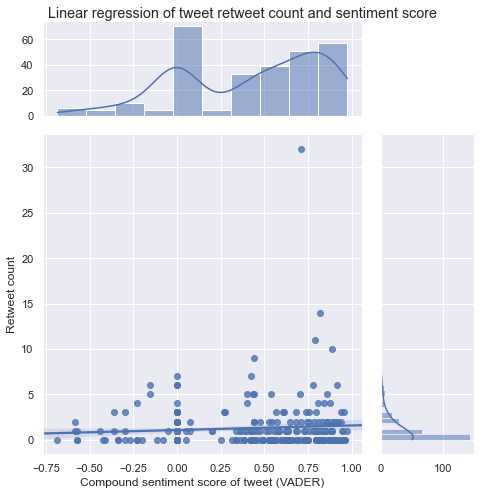

In [126]:
plt.figure(figsize=(8,8))
g = sns.jointplot(x="senti_score", y="favorites", data=original_tweets, kind="reg", truncate=False, height=7, ratio=3, marginal_ticks=True)
g.fig.suptitle('Linear regression of tweet favorite count and sentiment score')
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room for title
# g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.set_axis_labels('Compound sentiment score of tweet (VADER)','Favorite count')
plt.show()

plt.figure(figsize=(8,8))
g = sns.jointplot(x="senti_score", y="retweets", data=original_tweets, kind="reg", truncate=False, height=7, ratio=3, marginal_ticks=True)
g.fig.suptitle('Linear regression of tweet retweet count and sentiment score')
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room for title
# g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.set_axis_labels('Compound sentiment score of tweet (VADER)','Retweet count')
plt.show()
